In [76]:
import torch

network_config = {'Backbone': {'scale': 0.5, 'disable_se': True},
                'Neck': {'out_channels': 96, 'use_residual': True},
                'Head': {'k': 50}
            }

In [77]:
from model.detection_model import BaseDetectionModel

model = BaseDetectionModel(config=network_config)

In [78]:
model.load_state_dict(torch.load("model/checkpoints/en_ptocr_v3_det_infer.pth"))

<All keys matched successfully>

In [79]:
def convert_backbone_part(img, save_path, model):
    with torch.no_grad():
        backbone_output = model.backbone(img)
        torch.onnx.export(model.backbone, img, save_path, \
                        export_params=True, \
                        opset_version=12, \
                        do_constant_folding=True, \
                        verbose=True, \
                        input_names=['img'], \
                        output_names=['bk_output1', 'bk_output2', 'bk_output3', 'bk_output4'] \
                        )   
        
        return backbone_output
    
img = torch.rand(1, 3, 960, 960)
bk_output = convert_backbone_part(img, './onnx_weights/backbone.onnx', model)

graph(%img : Float(1, 3, 960, 960, strides=[2764800, 921600, 960, 1], requires_grad=0, device=cpu),
      %560 : Float(8, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=0, device=cpu),
      %561 : Float(8, strides=[1], requires_grad=0, device=cpu),
      %563 : Float(8, 8, 1, 1, strides=[8, 1, 1, 1], requires_grad=0, device=cpu),
      %564 : Float(8, strides=[1], requires_grad=0, device=cpu),
      %566 : Float(8, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=0, device=cpu),
      %567 : Float(8, strides=[1], requires_grad=0, device=cpu),
      %569 : Float(8, 8, 1, 1, strides=[8, 1, 1, 1], requires_grad=0, device=cpu),
      %570 : Float(8, strides=[1], requires_grad=0, device=cpu),
      %572 : Float(32, 8, 1, 1, strides=[8, 1, 1, 1], requires_grad=0, device=cpu),
      %573 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %575 : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=0, device=cpu),
      %576 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %

In [85]:
def convert_neck_part(inp, save_path, model):
    neck_outputs = model.neck(inp)
    torch.onnx.export(
        model.neck,
        inp,
        save_path,
        export_params=True,
        opset_version=12,
        do_constant_folding=True,
        input_names=['bk_output1', 'bk_output2', 'bk_output3', 'bk_output'],
        output_names=['neck_output'],
    )
    
    return neck_outputs

nk_output = convert_neck_part(bk_output, './onnx_weights/neck.onnx', model)
nk_output

tensor([[[[-153.7198, -153.7198, -153.7198,  ...,   49.2826,   49.2826,
             49.2826],
          [-153.7198, -153.7198, -153.7198,  ...,   49.2826,   49.2826,
             49.2826],
          [-153.7198, -153.7198, -153.7198,  ...,   49.2826,   49.2826,
             49.2826],
          ...,
          [  62.5473,   62.5473,   62.5473,  ...,   87.8257,   87.8257,
             87.8257],
          [  62.5473,   62.5473,   62.5473,  ...,   87.8257,   87.8257,
             87.8257],
          [  62.5473,   62.5473,   62.5473,  ...,   87.8257,   87.8257,
             87.8257]],

         [[  95.6913,   95.6913,   95.6913,  ...,  121.5576,  121.5576,
            121.5576],
          [  95.6913,   95.6913,   95.6913,  ...,  121.5576,  121.5576,
            121.5576],
          [  95.6913,   95.6913,   95.6913,  ...,  121.5576,  121.5576,
            121.5576],
          ...,
          [  43.5408,   43.5408,   43.5408,  ...,  348.9812,  348.9812,
            348.9812],
          [  43.54

In [81]:
def convert_head_part(inp, save_path, model):
    head_output = model.head(inp)
    
    torch.onnx.export(
        model.head,
        inp,
        save_path,
        export_params=True,
        opset_version=12,
        do_constant_folding=True,
        input_names=['nk_output'],
        output_names=['head_output']
    )
    
    return head_output

head_output = convert_head_part(nk_output, "./onnx_weights/head.onnx", model)
head_output

{'maps': tensor([[[[4.1916e-11, 6.5957e-13, 5.3600e-13,  ..., 4.0349e-10,
            1.0176e-10, 1.3354e-09],
           [1.4617e-11, 1.7543e-13, 1.1019e-13,  ..., 5.4097e-11,
            5.5963e-12, 9.2407e-11],
           [1.0161e-10, 5.5222e-12, 5.2161e-13,  ..., 1.2304e-08,
            1.7958e-09, 4.2387e-08],
           ...,
           [1.1987e-12, 7.9416e-13, 1.3796e-12,  ..., 6.9939e-06,
            4.4608e-06, 4.9159e-06],
           [8.1713e-12, 4.4412e-12, 1.0601e-10,  ..., 1.1707e-05,
            9.8716e-06, 1.2508e-05],
           [3.5501e-11, 2.0875e-11, 3.1090e-10,  ..., 7.3355e-06,
            5.8636e-06, 6.8136e-06]],
 
          [[4.7649e-01, 4.8549e-01, 4.0288e-01,  ..., 6.9041e-01,
            5.4216e-01, 5.1627e-01],
           [4.6388e-01, 4.7302e-01, 3.9614e-01,  ..., 5.9787e-01,
            5.2819e-01, 5.0137e-01],
           [3.7737e-01, 3.8859e-01, 4.0854e-01,  ..., 6.9019e-01,
            4.1760e-01, 3.6513e-01],
           ...,
           [4.6126e-01, 4.6595

In [102]:
import os
import onnx

def onnx_optim(onnxfile, save_onnxfile):
    onnx_path = os.path.abspath(os.path.expanduser(onnxfile))
    save_onnxpath = os.path.abspath(os.path.expanduser(save_onnxfile))
    save_dir = os.path.dirname(save_onnxpath)
    if not os.path.exists(onnx_path):
        raise FileNotFoundError('{} is not existed.'.format(onnx))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print('makedir: {}'.format(save_dir))
    onnx_model = onnx.load(onnxfile)
    passes = ["extract_constant_to_initializer", "eliminate_unused_initializer"]
    # from onnx import optimizer # too old
    import onnxoptimizer
    optimized_model = onnxoptimizer.optimize(onnx_model, passes)
    for idx in range(len(optimized_model.graph.input)):
        if optimized_model.graph.input[idx]:
            optimized_model.graph.input[idx].type.tensor_type.shape.dim[0].dim_param = '?'
            optimized_model.graph.input[idx].type.tensor_type.shape.dim[1].dim_param = '?'
            optimized_model.graph.input[idx].type.tensor_type.shape.dim[2].dim_param = '?'
            optimized_model.graph.input[idx].type.tensor_type.shape.dim[3].dim_param = '?'
    
    optimized_model.graph.output[0].type.tensor_type.shape.dim[0].dim_param = '?'
    optimized_model.graph.output[0].type.tensor_type.shape.dim[2].dim_param = '?'
    optimized_model.graph.output[0].type.tensor_type.shape.dim[3].dim_param = '?'

    onnx.save(optimized_model, save_onnxpath)
    print('{} is saved.'.format(save_onnxpath))

onnx_weight_dir = './onnx_weights/'
onnxfiles = os.listdir(onnx_weight_dir)

onnxpaths = [f"{onnx_weight_dir}/{onnxfile}" for onnxfile in onnxfiles]
for idx, onnxpath in enumerate(onnxpaths):
    onnx_optim(onnxpath, f"{onnx_weight_dir}/optim/{onnxfiles[idx]}")

makedir: /home/misa/Documents/KIE-MISA/cv-ext-service/onnx_weights/optim
/home/misa/Documents/KIE-MISA/cv-ext-service/onnx_weights/optim/backbone.onnx is saved.
/home/misa/Documents/KIE-MISA/cv-ext-service/onnx_weights/optim/head.onnx is saved.
/home/misa/Documents/KIE-MISA/cv-ext-service/onnx_weights/optim/neck.onnx is saved.


In [110]:
import onnx

# load model from onnx
backbone = onnx.load('./onnx_weights/optim/backbone.onnx')
neck = onnx.load('./onnx_weights/optim/neck.onnx')
head = onnx.load('./onnx_weights/optim/head.onnx')

# confirm model has valid schema
onnx.checker.check_model(backbone)
onnx.checker.check_model(neck)
onnx.checker.check_model(head)

# Print a human readable representation of the graph
onnx.helper.printable_graph(head.graph)

'graph torch-jit-export (\n  %nk_output[FLOAT, ?x?x?x?]\n) initializers (\n  %binarize.conv2.weight[FLOAT, 24x24x2x2]\n  %binarize.conv2.bias[FLOAT, 24]\n  %binarize.conv_bn2.weight[FLOAT, 24]\n  %binarize.conv_bn2.bias[FLOAT, 24]\n  %binarize.conv_bn2.running_mean[FLOAT, 24]\n  %binarize.conv_bn2.running_var[FLOAT, 24]\n  %binarize.conv3.weight[FLOAT, 24x1x2x2]\n  %binarize.conv3.bias[FLOAT, 1]\n  %40[FLOAT, 24x96x3x3]\n  %41[FLOAT, 24]\n) {\n  %39 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%nk_output, %40, %41)\n  %33 = Relu(%39)\n  %34 = ConvTranspose[dilations = [1, 1], group = 1, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%33, %binarize.conv2.weight, %binarize.conv2.bias)\n  %35 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%34, %binarize.conv_bn2.weight, %binarize.conv_bn2.bias, %binarize.conv_bn2.running_mean, %binarize.conv_bn2.running_var)\n  %36 = Relu(%35)\n  %37 

In [143]:
from model.detection_model.pre_process import transform, create_operators
import cv2

img_path = "doc/imgs_en/imgCV_0.jpg"
img = cv2.imread(img_path)

pre_process_list = [{
            'DetResize': {
                'limit_side_len': 960,
                'limit_type': 'max',
            }
        }, {
            'NormalizeImage': {
                'std': [0.229, 0.224, 0.225],
                'mean': [0.485, 0.456, 0.406],
                'scale': '1./255.',
                'order': 'hwc'
            }
        }, {
            'ToCHWImage': None
        }, {
            'KeepKeys': {
                'keep_keys': ['image', 'shape']
            }
        }]

pre_process_op = create_operators(pre_process_list)

In [144]:
data = {'image': img}
data = transform(data, pre_process_op)

import numpy as np
img, shape_list = data
img = np.expand_dims(img, axis=0)
shape_list = np.expand_dims(shape_list, axis=0)

In [146]:
import onnxruntime as ort

bk_ses = ort.InferenceSession("./onnx_weights/optim/backbone.onnx")
bk_inp = {bk_ses.get_inputs()[0].name: img}
bk_out = bk_ses.run(None, bk_inp)

2022-07-25 13:50:14.182670487 [W:onnxruntime:, execution_frame.cc:806 VerifyOutputSizes] Expected shape from model of {1,56,60,60} does not match actual shape of {1,56,60,42} for output bk_output3
2022-07-25 13:50:14.184937956 [W:onnxruntime:, execution_frame.cc:806 VerifyOutputSizes] Expected shape from model of {1,24,120,120} does not match actual shape of {1,24,120,84} for output bk_output2
2022-07-25 13:50:14.211190029 [W:onnxruntime:, execution_frame.cc:806 VerifyOutputSizes] Expected shape from model of {1,480,30,30} does not match actual shape of {1,480,30,21} for output bk_output4


In [147]:
import numpy as np

nk_ses = ort.InferenceSession("./onnx_weights/optim/neck.onnx")
nk_inp = {nk_ses.get_inputs()[idx].name: bk_out[idx] for idx in range(len(bk_out))}
nk_out = nk_ses.run(None, nk_inp)

In [154]:

hd_ses = ort.InferenceSession("./onnx_weights/optim/head.onnx")
hd_inp = {hd_ses.get_inputs()[0].name: nk_out[0]}
head_out = hd_ses.run(None, hd_inp)
head_out

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)]

In [149]:
postprocess_params = {}
postprocess_params['name'] = 'DBPostProcess'
postprocess_params["thresh"] = 0.3
postprocess_params["box_thresh"] = 0.7
postprocess_params["max_candidates"] = 1000
postprocess_params["unclip_ratio"] = 2.0
postprocess_params["use_dilation"] = False
postprocess_params["score_mode"] = "fast"

from model.detection_model.post_process.db_postprocess import DBPostProcess
postprocess_op = DBPostProcess.build(postprocess_params)

In [155]:
preds = {}
preds['maps'] = head_out[0]

In [156]:
post_result = postprocess_op(preds, shape_list)

In [175]:
dt_boxes = post_result[0]['points']
bboxes = dt_boxes.tolist()

In [178]:
result = []
for box in bboxes:
    result.append(box[0] + box[2])
    
print(result)
    

[[273, 2073, 345, 2112], [625, 2069, 805, 2108], [620, 2027, 844, 2071], [276, 2027, 423, 2066], [620, 1981, 935, 2017], [273, 1981, 411, 2020], [618, 1905, 1137, 1954], [271, 1908, 389, 1947], [621, 1822, 1036, 1864], [275, 1771, 454, 1826], [623, 1774, 1063, 1810], [726, 1737, 864, 1774], [721, 1698, 1312, 1740], [721, 1647, 1203, 1689], [726, 1598, 1135, 1635], [721, 1542, 1041, 1589], [276, 1542, 541, 1586], [625, 1503, 1147, 1540], [1228, 1469, 1396, 1506], [276, 1467, 564, 1503], [622, 1415, 724, 1460], [276, 1413, 404, 1452], [623, 1372, 805, 1411], [273, 1367, 345, 1406], [618, 1318, 741, 1364], [276, 1321, 423, 1360], [623, 1274, 970, 1311], [273, 1269, 411, 1308], [620, 1223, 741, 1262], [270, 1215, 390, 1268], [630, 1006, 1194, 1043], [273, 992, 620, 1033], [633, 953, 1125, 989], [635, 909, 709, 940], [628, 867, 1334, 909], [274, 867, 425, 912], [630, 816, 940, 853], [278, 816, 573, 853], [276, 763, 438, 799], [628, 758, 975, 802], [276, 711, 445, 748], [635, 711, 709, 743],

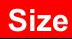

In [179]:
from PIL import Image

image = Image.open(img_path).convert("RGB")
img_crop1 = image.crop(result[0])

img_crop1